# Simplification of WDPA to be used in AOI
### Because the original WDPA layers are too heavy to be displayed, we create 3 simplified layers that will be used in different zoom levels:
##### 1. Detailed view: this will use the most simplified version, one in which some geometries can be removed
##### 2. Medium zoom levels: for this we will keep all geometries but simplify the geometries as much as possible
##### 3. Global zoom: for this we need a slightly simplified layer that preserves the shapes as much as possible and keeps all the geometries (except those that have null geometries). This layer will be heavier and only displayed at very detailed zooms.
#### The 3 simplifications will be made using mapshaper. We will base the simplification in the command used in Marxan, but testing different options to find the most efficient way to display each of these 3 layers.
Mapshaper commad used in Marxan:
!mapshaper -i /Users/tamarahuete/Documents/HALF_EARTH/Ecoregions2017_20210825.shp snap combine-files \
        -simplify 25% planar keep-shapes \
        -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
        -filter-slivers min-area=10000m2 remove-empty \
        -clean rewind \
        -o /Users/tamarahuete/Documents/HALF_EARTH/Ecoregions2017_20210825_simple.shp format=shapefile force ndjson

In [ ]:
# ## In terminal run to install mapshaper:
# !nvm use 12.21.0
# !npm i -g mapshaper@0.5.67

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas
import os
import json
from zipfile import ZipFile

## Terrestrial WDPAs

In [2]:
path = '/Users/sofia/Documents/HE_Data/WDPA'

In [3]:
%%time
# Read file (this is a layer only with terrestrial WDPA used for the AOI precalculated data, it was corrected in ArcGIS Pro to solve geometry problems)
gdf = gpd.read_file(f'{path}/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa_corrected/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa.shp')
len(gdf)

CPU times: user 32.2 s, sys: 1.78 s, total: 33.9 s
Wall time: 34.1 s


217424

In [4]:
gdf[gdf['WDPA_PID']=='394131'] # reading csv keeps original characters as they are

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID,geometry
177467,394131.0,394131,"""Fonds Gatot"" Et ""Laid Mâle""",Site Naturel D'Interêt Scientifique,National,IV,Designated,Federal or national ministry or agency,Not Reported,BEL,0.099415,177471,"MULTIPOLYGON (((4.76254 50.57918, 4.75987 50.5..."


Because converting the shp to json (for the simplification) changes the original characters of the names, let's create a new gdf that only contains the geometries and the MOL_ID of the WDPA. We'll do the simplification using these and join the required attributes for the original table later 

In [4]:
gdf2 = gdf[['MOL_ID','geometry']]

In [5]:
%%time
# Save file in local
gdf2.to_file(f'{path}/WDPA_Terrestrial_corrected_geomOnly', driver= 'ESRI Shapefile')

CPU times: user 4min 57s, sys: 7.35 s, total: 5min 5s
Wall time: 5min 7s


### Simplifications

#### 1. Low simplification (to be used at large scales with a greater amount of detail)

In [5]:
# Break the shp into 12 json files to make the process more efficient
!mapshaper-xl 16gb -i ./../../HE_Data/WDPA/WDPA_Terrestrial_corrected_geomOnly/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/20000)+1" \
    -split group \
    -o WDPA_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] Wrote WDPA_test/1.json
[o] Wrote WDPA_test/2.json
[o] Wrote WDPA_test/3.json
[o] Wrote WDPA_test/4.json
[o] Wrote WDPA_test/5.json
[o] Wrote WDPA_test/6.json
[o] Wrote WDPA_test/7.json
[o] Wrote WDPA_test/8.json
[o] Wrote WDPA_test/9.json
[o] Wrote WDPA_test/10.json
[o] Wrote WDPA_test/11.json


In [6]:
%%time
# Only simplify (retains all geometries).
!mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
    -simplify 50% weighting=0.3 planar keep-shapes \
    -o WDPA_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 6,153 intersections; 10,228 intersections could not be repaired
[o] Wrote WDPA_test/1.json
[i] Snapped 0 points
[simplify] Repaired 7,778 intersections; 33,199 intersections could not be repaired
[o] Wrote WDPA_test/10.json
[i] Snapped 0 points
[simplify] Repaired 0 intersections; 50,915 intersections could not be repaired
[o] Wrote WDPA_test/11.json
[i] Snapped 0 points
[simplify] Repaired 2,969 intersections; 16,387 intersections could not be repaired
[o] Wrote WDPA_test/2.json
[i] Snapped 0 points
[simplify] Repaired 3,146 intersections; 34,612 intersections could not be repaired
[o] Wrote WDPA_test/3.json
[i] Snapped 0 points
[simplify] Repaired 2,500 intersections; 15,127 intersections could not be repaired
[o] Wrote WDPA_test/4.json
[i] Snapped 0 points
[simplify] Repaired 2,045 intersections; 24,919 intersections could not be repaired
[o] Wrote WDPA_test/5.json
[i] Snapped 0 points
[simplify] Repaired 1,083

In [7]:
# Combine all json files in a shp. 
!mapshaper-xl 16gb -i ./WDPA_test/*.json combine-files -merge-layers -info -o WDPA_test/wdpa_simp1.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
-------------------------
Type:     polygon
Records:  217,424
Nulls:     440
Bounds:   -179.9999,-69.4778,179.9999,83.73
CRS:      +proj=longlat +datum=WGS84
Source:   ./WDPA_test/1.json

Attribute data
--------+-------------
 Field  | First value
--------+-------------
 group  | 1
 MOL_ID | 1
--------+-------------

[o] Wrote WDPA_test/wdpa_simp1.shp
[o] Wrote WDPA_test/wdpa_simp1.shx
[o] Wrote WDPA_test/wdpa_simp1.dbf
[o] Wrote WDPA_test/wdpa_simp1.prj


In [8]:
sim1 = gpd.read_file('WDPA_test/wdpa_simp1.shp') # len 217424, retains all geometries
len(sim1)

217424

In [9]:
## Set crs
sim1 = sim1.set_crs('EPSG:4326') 

In [10]:
%%time
# Repair geometries, in case some are invalid after simplification, and check how many are valid
sim1['geometry'] = sim1['geometry'].buffer(0) # this is to repair geometries
sum(sim1.is_valid) # now 216982 geometries valid so only 442 invalid

CPU times: user 35min 17s, sys: 52.3 s, total: 36min 10s
Wall time: 36min 21s


216982

In [11]:
%%time
# Keep only valid geometries and remove the 442 invalid
sim1 = sim1[sim1['geometry'].is_valid]
len(sim1)

CPU times: user 4min 20s, sys: 1.64 s, total: 4min 22s
Wall time: 4min 23s


216982

In [12]:
gdf.head(1)

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID,geometry
0,310492.0,310492,Boulder Beach,Stewardship Area,National,III,Designated,Federal or national ministry or agency,Department of Conservation,NZL,1.137712,1,"MULTIPOLYGON (((170.62746 -45.89520, 170.62824..."


In [13]:
sim1.head()

,MOL_ID,group,geometry
0,1,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62820..."
1,2,1,"POLYGON ((173.97640 -41.19260, 173.97350 -41.1..."
2,3,1,"POLYGON ((173.95690 -41.20980, 173.95510 -41.2..."
3,4,1,"POLYGON ((174.00240 -41.27340, 174.00340 -41.2..."
4,5,1,"MULTIPOLYGON (((169.53390 -46.44740, 169.53120..."


In [14]:
sim1 = sim1.drop(columns={'group'})
sim1.head()

,MOL_ID,geometry
0,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62820..."
1,2,"POLYGON ((173.97640 -41.19260, 173.97350 -41.1..."
2,3,"POLYGON ((173.95690 -41.20980, 173.95510 -41.2..."
3,4,"POLYGON ((174.00240 -41.27340, 174.00340 -41.2..."
4,5,"MULTIPOLYGON (((169.53390 -46.44740, 169.53120..."


In [15]:
gdf_no_geom = gdf.drop(columns='geometry')
gdf_no_geom.head(1)

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID
0,310492.0,310492,Boulder Beach,Stewardship Area,National,III,Designated,Federal or national ministry or agency,Department of Conservation,NZL,1.137712,1


In [16]:
import pandas as pd
sim1 = gpd.GeoDataFrame(pd.merge(sim1, gdf_no_geom,  how='left', left_on=['MOL_ID'], right_on = ['MOL_ID']))
sim1.head(1)

,MOL_ID,geometry,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM
0,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62820...",310492.0,310492,Boulder Beach,Stewardship Area,National,III,Designated,Federal or national ministry or agency,Department of Conservation,NZL,1.137712


In [17]:
sim1 = sim1.rename(columns={'AREA_KM':'AREA_KM2'})
sim1.columns

Index(['MOL_ID', 'geometry', 'WDPAID', 'WDPA_PID', 'NAME', 'DESIG', 'DESIG_T',
       'IUCN_CA', 'STATUS', 'GOV_TYP', 'MANG_AU', 'ISO3', 'AREA_KM2'],
      dtype='object')

In [18]:
gdf[gdf['MOL_ID']==14318]

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID,geometry
14317,55558010.0,55558010,Quinnipiac River,State Park,National,III,Designated,Sub-national ministry or agency,Other or Unknown State Land ; State Department...,USA,1.411278,14318,"MULTIPOLYGON (((-72.84705 41.44000, -72.84750 ..."


<AxesSubplot:>

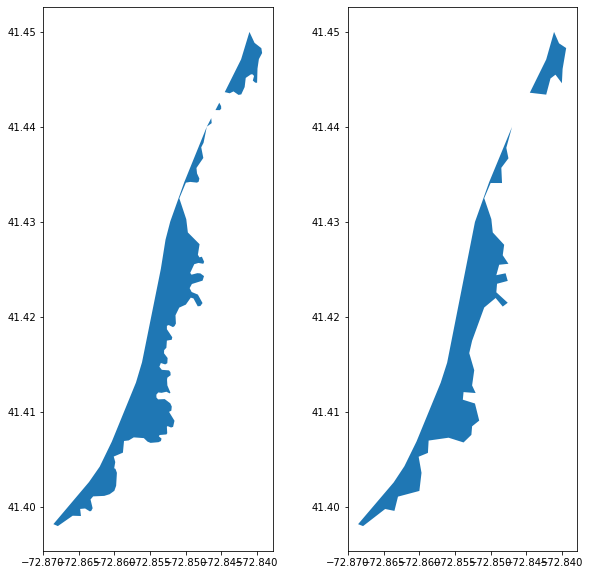

In [19]:
# Compare geometries in original and simplified dataset
n= 14318
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['MOL_ID']==n].geometry.plot(ax = ax1) 
sim1[sim1['MOL_ID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

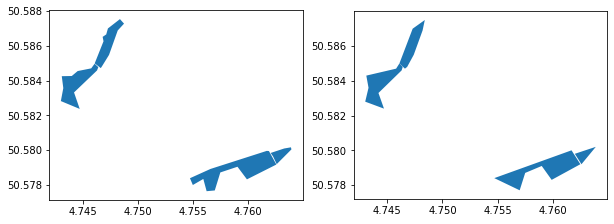

In [20]:
# Compare geometries in original and simplified dataset
n= '394131'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

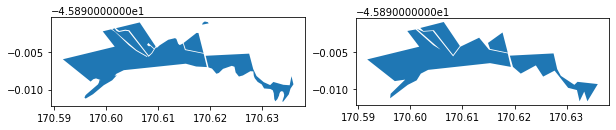

In [21]:
n= '310492'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

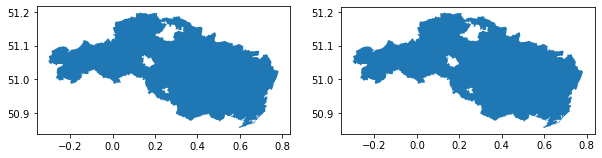

In [22]:
n = '20609'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

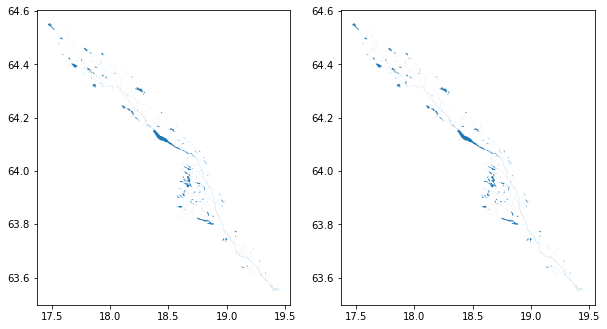

In [23]:
n = '555534655'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

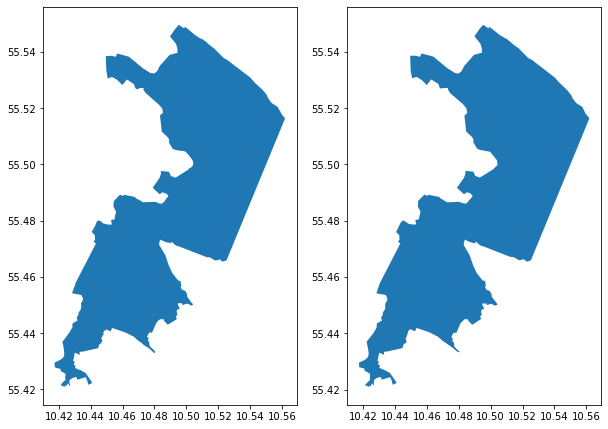

In [24]:
n = '555703244'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

In [25]:
# Save file in local
sim1.to_file(f'{path}/Simplifications/WDPA_Ter_Simp50b', driver= 'ESRI Shapefile')

#### 2. Mid simplification (to be used at medium scales with a medium amount of detail)

In [ ]:
# Break the shp into 12 json files to make the process more efficient
!mapshaper-xl 16gb -i ./../../HE_Data/WDPA/WDPA_Terrestrial_corrected_geomOnly/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/20000)+1" \
    -split group \
    -o WDPA_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] Wrote WDPA_test/1.json
[o] Wrote WDPA_test/2.json
[o] Wrote WDPA_test/3.json
[o] Wrote WDPA_test/4.json
[o] Wrote WDPA_test/5.json
[o] Wrote WDPA_test/6.json
[o] Wrote WDPA_test/7.json
[o] Wrote WDPA_test/8.json
[o] Wrote WDPA_test/9.json
[o] Wrote WDPA_test/10.json
[o] Wrote WDPA_test/11.json


In [6]:
%%time
# Only simplify (removes some geometries).
!mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
    -simplify 20% weighting=0.3 planar keep-shapes \
    -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
    -filter-slivers min-area=10000m2 remove-empty \
    -clean rewind \
    -o WDPA_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 6,388 intersections; 5,114 intersections could not be repaired
[filter-islands] Removed 36,413 islands
[filter-slivers] Removed 9,518 slivers using 0.01+ sqkm variable threshold
[clean] Removed 1,456 / 4,050 slivers using 0.086+ sqkm variable threshold
[clean] Retained 16,808 of 18,439 features
[o] Wrote WDPA_test/1.json
[i] Snapped 0 points
[simplify] Repaired 7,694 intersections; 17,475 intersections could not be repaired
[filter-islands] Removed 32,399 islands
[filter-slivers] Removed 9,511 slivers using 0.01+ sqkm variable threshold
[clean] Removed 3,329 / 4,981 slivers using 0.065+ sqkm variable threshold
[clean] Retained 16,504 of 18,509 features
[o] Wrote WDPA_test/10.json
[i] Snapped 0 points
[simplify] Repaired 6,469 intersections; 18,108 intersections could not be repaired
[filter-islands] Removed 51,380 islands
[filter-slivers] Removed 30,747 slivers using 0.01+ sqkm variable threshold
[clean] Removed 7

In [7]:
# Combine all json files in a shp.
!mapshaper-xl 16gb -i ./WDPA_test/*.json combine-files -merge-layers -info -o WDPA_test/wdpa_simp2.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
-------------------------
Type:     polygon
Records:  176,733
Bounds:   -179.9999,-69.4778,179.9999,83.73
CRS:      +proj=longlat +datum=WGS84
Source:   ./WDPA_test/1.json

Attribute data
--------+-------------
 Field  | First value
--------+-------------
 group  | 1
 MOL_ID | 1
--------+-------------

[o] Wrote WDPA_test/wdpa_simp2.shp
[o] Wrote WDPA_test/wdpa_simp2.shx
[o] Wrote WDPA_test/wdpa_simp2.dbf
[o] Wrote WDPA_test/wdpa_simp2.prj


In [8]:
%%time
sim2 = gpd.read_file('WDPA_test/wdpa_simp2.shp') # len 217424, retains all geometries
len(sim2)

CPU times: user 14.5 s, sys: 1.34 s, total: 15.8 s
Wall time: 16 s


176733

In [9]:
len(gdf)-len(sim2) # 40,691 geometries removed in this simplification

40691

In [10]:
## Set crs
sim2 = sim2.set_crs('EPSG:4326') 

In [11]:
%%time
# Repair geometries, in case some are invalid after simplification, and check how many are valid
sim2['geometry'] = sim2['geometry'].buffer(0) # this is to repair geometries
sum(sim2.is_valid) # 176733 valid (the same after simplification)

CPU times: user 10min 33s, sys: 14.3 s, total: 10min 47s
Wall time: 10min 56s


176733

In [14]:
# Keep only valid geometries and remove the 442 invalid
# sim2 = sim2[sim2['geometry'].is_valid]
# len(sim2)

176733

In [9]:
gdf.head(1)

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID,geometry
0,310492.0,310492,Boulder Beach,Stewardship Area,National,III,Designated,Federal or national ministry or agency,Department of Conservation,NZL,1.137712,1,"MULTIPOLYGON (((170.62746 -45.89520, 170.62824..."


In [10]:
sim2.head()

,MOL_ID,group,geometry
0,1,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62820..."
1,2,1,"POLYGON ((173.97640 -41.19260, 173.97590 -41.1..."
2,3,1,"POLYGON ((173.95690 -41.20980, 173.95580 -41.2..."
3,4,1,"POLYGON ((174.00240 -41.27340, 174.00310 -41.2..."
4,5,1,"MULTIPOLYGON (((169.30640 -46.57950, 169.30750..."


In [15]:
sim2 = sim2.drop(columns={'group'})
sim2.head()

,MOL_ID,geometry
0,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62890..."
1,2,"POLYGON ((173.97640 -41.19260, 173.97110 -41.1..."
2,3,"POLYGON ((173.95690 -41.20980, 173.95510 -41.2..."
3,4,"POLYGON ((174.00240 -41.27340, 174.00880 -41.2..."
4,5,"MULTIPOLYGON (((169.53390 -46.44740, 169.53120..."


In [16]:
gdf_no_geom = gdf.drop(columns='geometry')
gdf_no_geom.head(1)

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID
0,310492.0,310492,Boulder Beach,Stewardship Area,National,III,Designated,Federal or national ministry or agency,Department of Conservation,NZL,1.137712,1


In [17]:
import pandas as pd
sim2 = gpd.GeoDataFrame(pd.merge(sim2, gdf_no_geom,  how='left', left_on=['MOL_ID'], right_on = ['MOL_ID']))
sim2.head(1)

,MOL_ID,geometry,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM
0,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62890...",310492.0,310492,Boulder Beach,Stewardship Area,National,III,Designated,Federal or national ministry or agency,Department of Conservation,NZL,1.137712


In [18]:
sim2 = sim2.rename(columns={'AREA_KM':'AREA_KM2'})
sim2.columns

Index(['MOL_ID', 'geometry', 'WDPAID', 'WDPA_PID', 'NAME', 'DESIG', 'DESIG_T',
       'IUCN_CA', 'STATUS', 'GOV_TYP', 'MANG_AU', 'ISO3', 'AREA_KM2'],
      dtype='object')

In [19]:
len(sim2)

176733

In [20]:
gdf[gdf['MOL_ID']==14318]

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID,geometry
14317,55558010.0,55558010,Quinnipiac River,State Park,National,III,Designated,Sub-national ministry or agency,Other or Unknown State Land ; State Department...,USA,1.411278,14318,"MULTIPOLYGON (((-72.84705 41.44000, -72.84750 ..."


<AxesSubplot:>

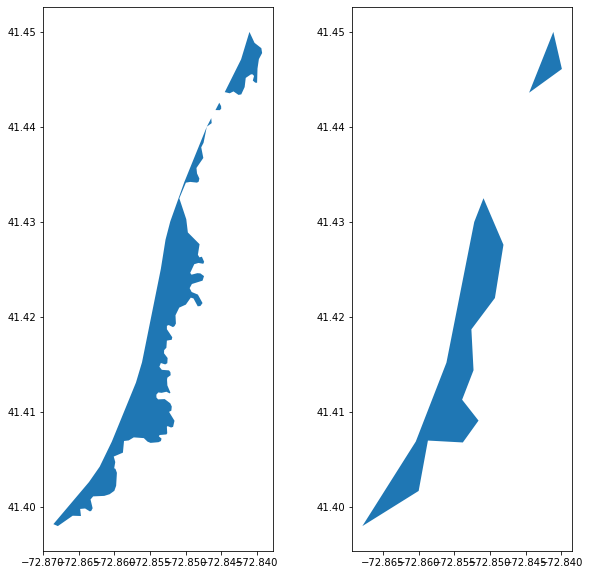

In [21]:
# Compare geometries in original and simplified dataset
n= 14318
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['MOL_ID']==n].geometry.plot(ax = ax1) 
sim2[sim2['MOL_ID']==n].geometry.plot(ax = ax2)

In [ ]:
gdf.

<AxesSubplot:>

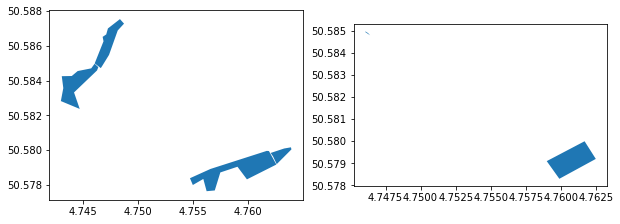

In [23]:
# Compare geometries in original and simplified dataset
n= '394131'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

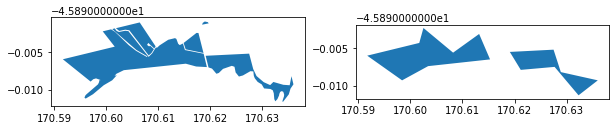

In [24]:
n= '310492'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

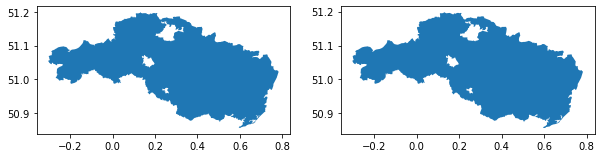

In [27]:
n = '20609'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

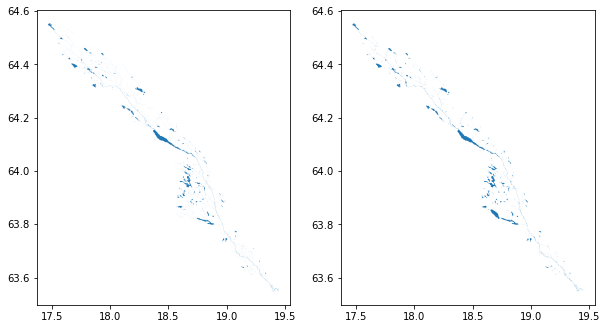

In [28]:
n = '555534655'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

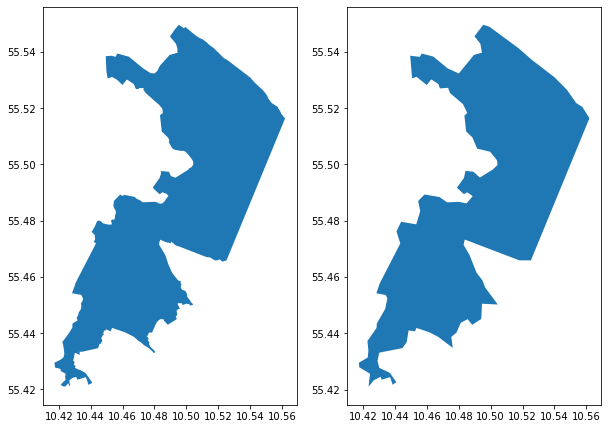

In [29]:
n = '555703244'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

In [30]:
# Save file in local
sim2.to_file(f'{path}/Simplifications/WDPA_Ter_Simp80', driver= 'ESRI Shapefile')

#### 3. High simplification (to be used at global scale with very low detail)

In [89]:
# Break the shp into 12 json files to make the process more efficient
!mapshaper-xl 16gb -i ./../../HE_Data/WDPA/WDPA_Terrestrial_corrected_geomOnly/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/20000)+1" \
    -split group \
    -o WDPA_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] Wrote WDPA_test/1.json
[o] Wrote WDPA_test/2.json
[o] Wrote WDPA_test/3.json
[o] Wrote WDPA_test/4.json
[o] Wrote WDPA_test/5.json
[o] Wrote WDPA_test/6.json
[o] Wrote WDPA_test/7.json
[o] Wrote WDPA_test/8.json
[o] Wrote WDPA_test/9.json
[o] Wrote WDPA_test/10.json
[o] Wrote WDPA_test/11.json


In [90]:
%%time
# Only simplify (removes some geometries).
!mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
    -simplify 1% weighting=0.3 planar keep-shapes \
    -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
    -filter-slivers min-area=10000m2 remove-empty \
    -clean rewind \
    -o WDPA_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 2,144 intersections; 1,386 intersections could not be repaired
[filter-islands] Removed 50,997 islands
[filter-slivers] Removed 14,071 slivers using 0.01+ sqkm variable threshold
[clean] Removed 244 / 387 slivers using 0.5+ sqkm variable threshold
[clean] Retained 16,655 of 18,427 features
[o] Wrote WDPA_test/1.json
[i] Snapped 0 points
[simplify] Repaired 2,516 intersections; 9,694 intersections could not be repaired
[filter-islands] Removed 43,080 islands
[filter-slivers] Removed 11,298 slivers using 0.01+ sqkm variable threshold
[clean] Removed 935 / 1,066 slivers using 0.3+ sqkm variable threshold
[clean] Retained 16,244 of 18,493 features
[o] Wrote WDPA_test/10.json
[i] Snapped 0 points
[simplify] Repaired 6,332 intersections; 4,416 intersections could not be repaired
[filter-islands] Removed 83,992 islands
[filter-slivers] Removed 34,600 slivers using 0.01+ sqkm variable threshold
[clean] Removed 1,162 / 1,4

In [73]:
# Combine all json files in a shp. 
!mapshaper-xl 16gb -i ./WDPA_test/*.json combine-files -merge-layers -info -o WDPA_test/wdpa_simp3.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
-------------------------
Type:     polygon
Records:  174,448
Bounds:   -179.9998,-69.4774,179.9997,83.73
CRS:      +proj=longlat +datum=WGS84
Source:   ./WDPA_test/1.json

Attribute data
--------+-------------
 Field  | First value
--------+-------------
 group  | 1
 MOL_ID | 1
--------+-------------

[o] Wrote WDPA_test/wdpa_simp3.shp
[o] Wrote WDPA_test/wdpa_simp3.shx
[o] Wrote WDPA_test/wdpa_simp3.dbf
[o] Wrote WDPA_test/wdpa_simp3.prj


In [74]:
sim3 = gpd.read_file('WDPA_test/wdpa_simp3.shp') 
len(sim3)

174448

In [75]:
len(gdf)-len(sim3) # 42976 geometries removed during simplification

42976

In [76]:
## Set crs
sim3 = sim3.set_crs('EPSG:4326') 

In [77]:
%%time
# Repair geometries, in case some are invalid after simplification, and check how many are valid
sim3['geometry'] = sim3['geometry'].buffer(0) # this is to repair geometries
sum(sim3.is_valid) # 174448 valid (same as after simplification)

CPU times: user 1min 13s, sys: 1.46 s, total: 1min 14s
Wall time: 1min 15s


174448

In [ ]:
# Keep only valid geometries and remove the invalid
# sim3 = sim3[sim3['geometry'].is_valid]
# len(sim3) # geometries less than original dataset

In [13]:
gdf.head(1)

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID,geometry
0,310492.0,310492,Boulder Beach,Stewardship Area,National,III,Designated,Federal or national ministry or agency,Department of Conservation,NZL,1.137712,1,"MULTIPOLYGON (((170.62746 -45.89520, 170.62824..."


In [38]:
sim3.head()

,MOL_ID,group,geometry
0,1,1,"POLYGON ((170.60250 -45.89230, 170.60820 -45.8..."
1,2,1,"POLYGON ((173.97640 -41.19260, 173.96920 -41.1..."
2,3,1,"POLYGON ((173.95690 -41.20980, 173.95510 -41.2..."
3,4,1,"POLYGON ((174.00240 -41.27340, 174.00880 -41.2..."
4,5,1,"MULTIPOLYGON (((169.53390 -46.44740, 169.52510..."


In [78]:
sim3 = sim3.drop(columns={'group'})
sim3.head()

,MOL_ID,geometry
0,1,"POLYGON ((170.60250 -45.89230, 170.59840 -45.8..."
1,2,"POLYGON ((173.97640 -41.19260, 173.96920 -41.1..."
2,3,"POLYGON ((173.95690 -41.20980, 173.95510 -41.2..."
3,4,"POLYGON ((174.00240 -41.27340, 174.00880 -41.2..."
4,5,"POLYGON ((169.21100 -46.55450, 169.15820 -46.5..."


In [79]:
gdf_no_geom = gdf.drop(columns='geometry')
gdf_no_geom.head(1)

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID
0,310492.0,310492,Boulder Beach,Stewardship Area,National,III,Designated,Federal or national ministry or agency,Department of Conservation,NZL,1.137712,1


In [80]:
import pandas as pd
sim3 = gpd.GeoDataFrame(pd.merge(sim3, gdf_no_geom,  how='left', left_on=['MOL_ID'], right_on = ['MOL_ID']))
sim3.head(1)

,MOL_ID,geometry,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM
0,1,"POLYGON ((170.60250 -45.89230, 170.59840 -45.8...",310492.0,310492,Boulder Beach,Stewardship Area,National,III,Designated,Federal or national ministry or agency,Department of Conservation,NZL,1.137712


In [81]:
sim3 = sim3.rename(columns={'AREA_KM':'AREA_KM2'})
sim3.columns

Index(['MOL_ID', 'geometry', 'WDPAID', 'WDPA_PID', 'NAME', 'DESIG', 'DESIG_T',
       'IUCN_CA', 'STATUS', 'GOV_TYP', 'MANG_AU', 'ISO3', 'AREA_KM2'],
      dtype='object')

In [63]:
gdf[gdf['MOL_ID']==14318]

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID,geometry
14317,55558010.0,55558010,Quinnipiac River,State Park,National,III,Designated,Sub-national ministry or agency,Other or Unknown State Land ; State Department...,USA,1.411278,14318,"MULTIPOLYGON (((-72.84705 41.44000, -72.84750 ..."


<AxesSubplot:>

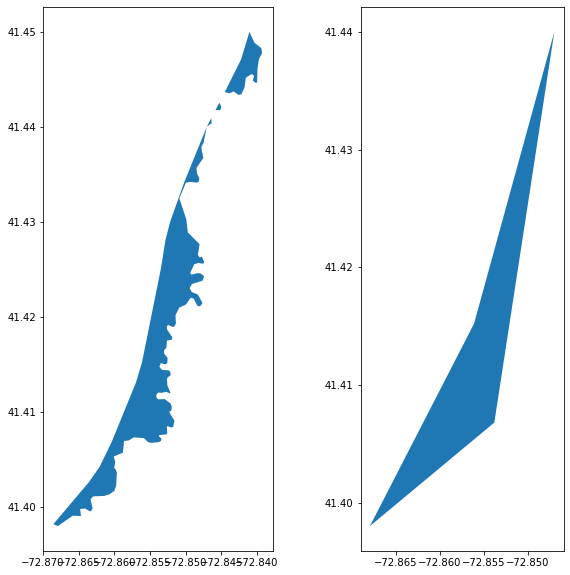

In [82]:
# Compare geometries in original and simplified dataset
n= 14318
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['MOL_ID']==n].geometry.plot(ax = ax1) 
sim3[sim3['MOL_ID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

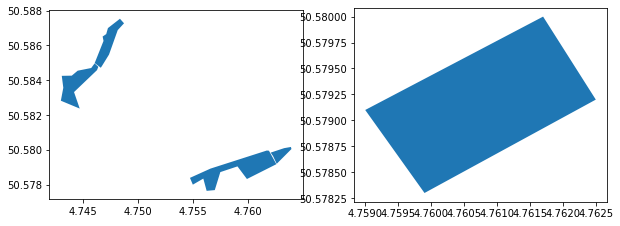

In [83]:
# Compare geometries in original and simplified dataset
n= '394131'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim3[sim3['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

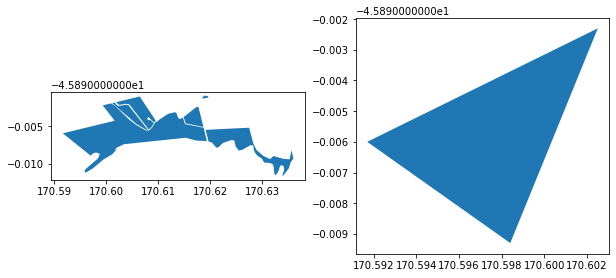

In [84]:
n= '310492'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim3[sim3['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

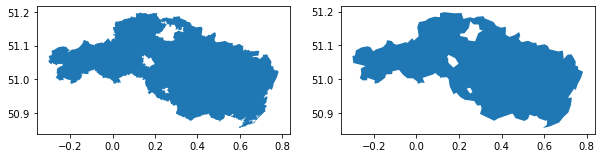

In [85]:
n = '20609'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim3[sim3['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

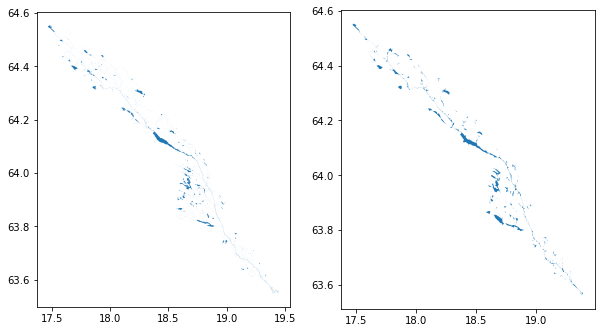

In [86]:
n = '555534655'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim3[sim3['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

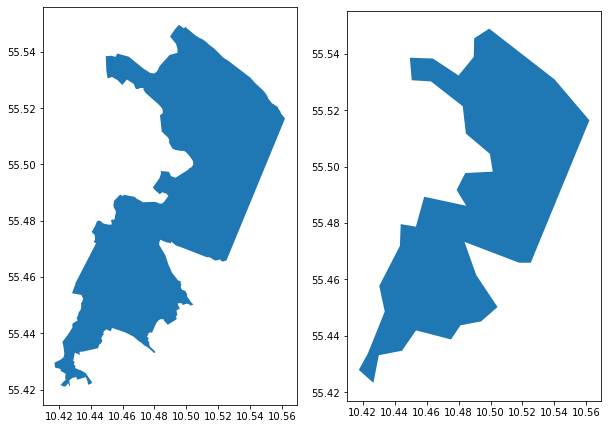

In [87]:
n = '555703244'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim3[sim3['WDPA_PID']==n].geometry.plot(ax = ax2)

In [88]:
# Save file in local
sim3.to_file(f'{path}/Simplifications/WDPA_Ter_Simp99', driver= 'ESRI Shapefile')

---------------
## Marine WDPA (pending)

In [2]:
# Create unzipped folder so mapshaper can bring the shp
zipfile = '/Users/sofia/Documents/HE_Data/WDPA_FILTERED_20210615_FILTERED_all_with_oecm_wdpa_100mTol'
unzipfile = ZipFile(f'{zipfile}.zip').extractall(zipfile)
# file_in = f'{zipfile}/WDPA_FILTERED_20210615_FILTERED_all_with_oecm_wdpa_100mTol.shp'
# file_out = '/Users/sofia/Documents/HE_Data/WDPA_simple.shp'

In [ ]:
### Inspect file
# gdf = gpd.read_file(file_in)

In [2]:
# Read file
gdf = gpd.read_file('zip:///Users/sofia/Documents/HE_Data/WDPA_FILTERED_20210615_FILTERED_all_with_oecm_wdpa_100mTol.zip')
len(gdf)

224133

In [3]:
gdf[gdf['WDPA_PID']=='394131'] # reading csv keeps original characters as they are

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
177470,394131.0,394131,1,"""Fonds Gatot"" Et ""Laid Mâle""","""Fonds Gatot"" Et ""Laid Mâle""",Site Naturel D'Interêt Scientifique,Scientific Interest Site (Walloon Region),National,IV,Not Applicable,...,BEL,Not Applicable,Not Applicable,0.0,737c7794,-1628145044,-1628145044,0.100151,177471,"MULTIPOLYGON (((4.76254 50.57918, 4.75696 50.5..."


#### There are two WDPA that have weird geometries due to antimeridian:
WDPA=220201 and WDPA= 555624810
#### These geometries need to be replaced by the correct ones (downloaded from protected planet)

In [6]:
## New geometries
new1 = gpd.read_file('zip:///Users/sofia/Documents/HE_Data/WDPA_220201.zip')
new2= gpd.read_file('zip:///Users/sofia/Documents/HE_Data/WDPA_555624810.zip')


<AxesSubplot:>

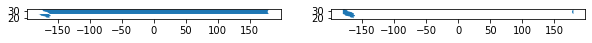

In [7]:
## See example
n = 220201 
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPAID']==n].geometry.plot(ax = ax1) 
new1[new1['WDPAID']==n].geometry.plot(ax = ax2)

In [8]:
## Get index for the geometry in gdf
gdf['geometry'][gdf['WDPA_PID'] == '220201']

220579    MULTIPOLYGON (((-163.00000 25.38976, -163.0000...
Name: geometry, dtype: geometry

In [9]:
## Get index for geometry in new datasets
new2['geometry'][new2['WDPA_PID'] == '555624810_E']

0    POLYGON ((-180.00000 -76.00000, -180.00000 -73...
Name: geometry, dtype: geometry

In [10]:
## Replace geometries with correct ones
gdf.loc[220579, 'geometry']= new1.loc[[0], 'geometry'].values
gdf.loc[207113, 'geometry']= new2.loc[[1], 'geometry'].values
gdf.loc[222498, 'geometry']= new2.loc[[2], 'geometry'].values
gdf.loc[222499, 'geometry']= new2.loc[[3], 'geometry'].values
gdf.loc[222500, 'geometry']= new2.loc[[4], 'geometry'].values
gdf.loc[222496, 'geometry']= new2.loc[[0], 'geometry'].values

In [11]:
# Create subset with only relevant columns
sub = gdf[['WDPAID','WDPA_PID','NAME','ORIG_NA','DESIG','DESIG_E','DESIG_T','IUCN_CA','MARINE','GOV_TYP','ISO3','OWN_TYP','AREA_KM','MOL_ID','geometry']]

In [13]:
# Save file in local
sub.to_file('/Users/sofia/Documents/HE_Data/WDPA_corrected', driver= 'ESRI Shapefile')

In [4]:
c = gpd.read_file('/Users/sofia/Documents/HE_Data/WDPA_corrected')

In [5]:
c[c['WDPA_PID']=='394131'] # original characters still there

,WDPAID,WDPA_PID,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,MARINE,GOV_TYP,ISO3,OWN_TYP,AREA_KM,MOL_ID,geometry
177470,394131.0,394131,"""Fonds Gatot"" Et ""Laid Mâle""","""Fonds Gatot"" Et ""Laid Mâle""",Site Naturel D'Interêt Scientifique,Scientific Interest Site (Walloon Region),National,IV,0,Federal or national ministry or agency,BEL,Not Reported,0.100151,177471,"MULTIPOLYGON (((4.76254 50.57918, 4.75696 50.5..."


#### Simplification is done in the he-scratch folder, but the outputs have been removed to avoid space issues
Note: Run the mapshaper commands directly in terminal if it doesn't work here

#### Create partitions to make the process more efficient

In [6]:
# Break the shp into 12 json files
!mapshaper-xl 16gb -i ./../../HE_Data/WDPA_corrected/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/20000)+1" \
    -split group \
    -o WDPA_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] Wrote WDPA_test/1.json
[o] Wrote WDPA_test/2.json
[o] Wrote WDPA_test/3.json
[o] Wrote WDPA_test/4.json
[o] Wrote WDPA_test/5.json
[o] Wrote WDPA_test/6.json
[o] Wrote WDPA_test/7.json
[o] Wrote WDPA_test/8.json
[o] Wrote WDPA_test/9.json
[o] Wrote WDPA_test/10.json
[o] Wrote WDPA_test/11.json
[o] Wrote WDPA_test/12.json


In [ ]:
## To merge all json files in one
# !mapshaper-xl 16gb -i ./../../HALF_EARTH/WDPA_test/*.json snap combine-files -merge-layers -info

### Tests:
1. All commands: len 183665 (symp-wdpa.shp)
2. Remove the 'filter-slivers' option = len 19833 (symp-wdpa2.shp)
3. Remove the 'filter-slivers' and 'filter islands' option = len (symp-wdpa3.shp)
This option removes >8000 geometries but all of them (except for 1) are valid
4. Remove the clean rewind option.
The 4th option retains all geometries, but 3935 are invalid. Some of those can be repaired and only 1611 have to be removed.

##### * Each test changes the json files so to run a new test it's necessary to run the previous cells to create the partitions again

In [ ]:
### First test with all parameters
# !mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
#     -simplify 20% planar keep-shapes \
#     -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
#     -filter-slivers min-area=10000m2 remove-empty \
#     -clean rewind \
#     -o WDPA_test/ format=geojson force ndjson

In [7]:
### Final test: Only simplify (retains all geometries).
!mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
    -simplify 20% weighting=0.3 planar keep-shapes \
    -o WDPA_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 2,846 intersections; 3,472 intersections could not be repaired
[o] Wrote WDPA_test/1.json
[i] Snapped 0 points
[simplify] Repaired 2,964 intersections; 8,909 intersections could not be repaired
[o] Wrote WDPA_test/10.json
[i] Snapped 0 points
[simplify] Repaired 0 intersections; 22,873 intersections could not be repaired
[o] Wrote WDPA_test/11.json
[i] Snapped 0 points
[simplify] Repaired 0 intersections; 15,327 intersections could not be repaired
[o] Wrote WDPA_test/12.json
[i] Snapped 0 points
[simplify] Repaired 696 intersections; 6,754 intersections could not be repaired
[o] Wrote WDPA_test/2.json
[i] Snapped 0 points
[simplify] Repaired 2,523 intersections; 12,784 intersections could not be repaired
[o] Wrote WDPA_test/3.json
[i] Snapped 0 points
[simplify] Repaired 538 intersections; 5,229 intersections could not be repaired
[o] Wrote WDPA_test/4.json
[i] Snapped 0 points
[simplify] Repaired 241 intersection

In [8]:
# Combine all json files in a shp. 
!mapshaper-xl 16gb -i ./WDPA_test/*.json combine-files -merge-layers -info -o WDPA_test/simp-wdpa4.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
--------------------------------------------------
Type:     polygon
Records:  224,133
Nulls:     1,614
Bounds:   -180,-85.4119,180,86.4531
CRS:      +proj=longlat +datum=WGS84
Source:   ./WDPA_test/1.json

Attribute data
----------+---------------------------------------
 Field    | First value
----------+---------------------------------------
 AREA_KM  |      1.136031298847187
 DESIG    | 'Stewardship Area'
 DESIG_E  | 'Stewardship Area'
 DESIG_T  | 'National'
 GOV_TYP  | 'Federal or national ministry or agency'
 group    |      1
 ISO3     | 'NZL'
 IUCN_CA  | 'III'
 MARINE   | '0'
 MOL_ID   |      1
 NAME     | 'Boulder Beach'
 ORIG_NA  | 'Boulder Beach / WWF Block'
 OWN_TYP  | 'Not Reported'
 WDPA_PID | '310492'
 WDPAID   | 310492
----------+---------------------------------------

[o] Wrote WDPA_test/simp-wdpa4.shp
[o] Wrote WDPA_test/simp-wdpa4.shx
[o] Wrote WDPA_test/simp-wdpa4.dbf
[o] Wrote WDPA_test/simp-wdpa4.

In [9]:
### Inspect file
# original layer len 224133
#sim = gpd.read_file('WDPA_test/simp-wdpa.shp') # len 183665
#sim = gpd.read_file('WDPA_test/simp-wdpa2.shp') # len 19833
#sim = gpd.read_file('WDPA_test/simp-wdpa3.shp') # len 215940 ### with clean rewind (8193 geometries removed)
sim = gpd.read_file('WDPA_test/simp-wdpa4.shp') # len 224133 ### retains all geometries
len(sim)

224133

In [10]:
sim[sim['WDPA_PID']=='394131'] # original characters are replaced by weird ones

,WDPAID,WDPA_PID,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,MARINE,GOV_TYP,ISO3,OWN_TYP,AREA_KM,MOL_ID,group,geometry
221603,394131,394131,"""Fonds Gatot"" Et ""Laid MÃ¢le""","""Fonds Gatot"" Et ""Laid MÃ¢le""",Site Naturel D'InterÃªt Scientifique,Scientific Interest Site (Walloon Region),National,IV,0,Federal or national ministry or agency,BEL,Not Reported,0.100151,177471,9,"POLYGON ((4.76250 50.57920, 4.75700 50.57770, ..."


#### Creating a shapefile from json files changes original characters in the names. To keep the original names but use the simplified geometry: drop geometry column in corrected dataset and add geometry column from simplified dataset

In [11]:
c = c.drop(columns=['geometry'])
c.head(1)

,WDPAID,WDPA_PID,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,MARINE,GOV_TYP,ISO3,OWN_TYP,AREA_KM,MOL_ID
0,310492.0,310492,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,III,0,Federal or national ministry or agency,NZL,Not Reported,1.136031,1


In [12]:
c = c.merge(sim[['WDPA_PID','geometry']],how='inner',on='WDPA_PID')
c.head(1)

,WDPAID,WDPA_PID,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,MARINE,GOV_TYP,ISO3,OWN_TYP,AREA_KM,MOL_ID,geometry
0,310492.0,310492,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,III,0,Federal or national ministry or agency,NZL,Not Reported,1.136031,1,"POLYGON ((170.60250 -45.89230, 170.61930 -45.8..."


<AxesSubplot:>

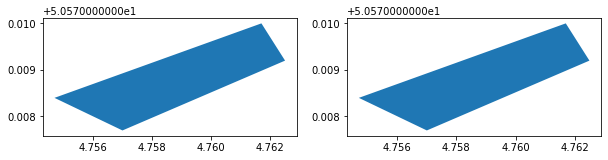

In [13]:
# check if new geometries in corrected database are the same as the simplified
n= '394131'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
c[c['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim[sim['WDPA_PID']==n].geometry.plot(ax = ax2)

In [14]:
## Set crs
c = c.set_crs('EPSG:4326') 

In [15]:
## Check if there are invalid geometries
sum(c.is_valid) # now 2220154 geometries valid so 3979 invalid

220154

In [17]:
## Repair geometries and check how many are valid
c['geometry'] = c['geometry'].buffer(0) # this is to repair geometries
sum(c.is_valid) # now 222519 geometries valid so only 1614 invalid

222519

In [18]:
## Keep only valid geometries and remove the 1611 invalid
c_clean = c[c['geometry'].is_valid]
len(c_clean)

222519

<AxesSubplot:>

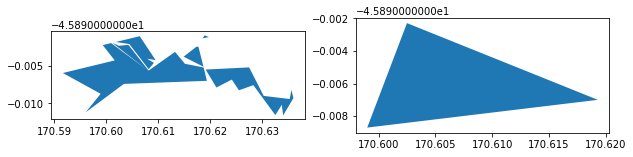

In [19]:
## Example
n= '310492'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
c_clean[c_clean['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

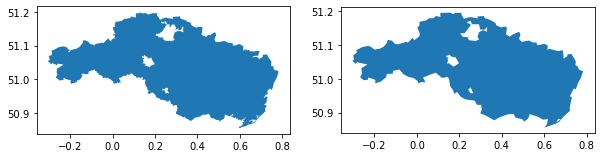

In [20]:
## Example
n = '20609'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
c_clean[c_clean['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

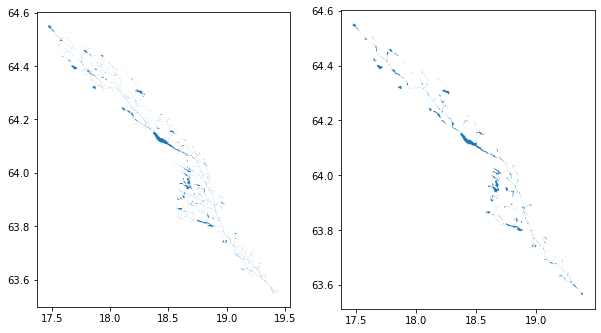

In [21]:
## Example
n = '555534655'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
c_clean[c_clean['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

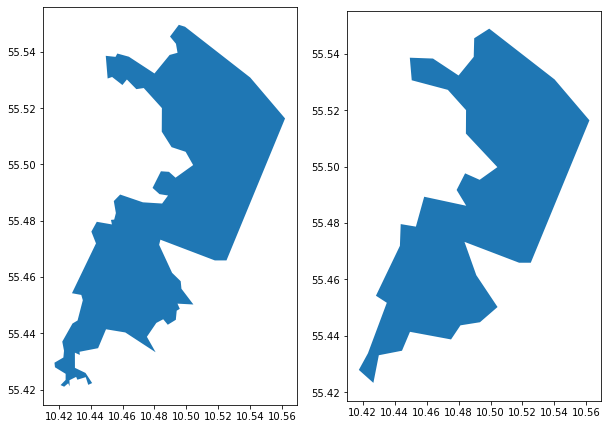

In [34]:
## Example
n = '555703244'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gdf[gdf['WDPA_PID']==n].geometry.plot(ax = ax1) 
c_clean[c_clean['WDPA_PID']==n].geometry.plot(ax = ax2)

In [50]:
# Save file in local
c_clean.to_file('/Users/sofia/Documents/HE_Data/WDPA_terrestrial+marine2021_simplified', driver= 'ESRI Shapefile')

### Publish layers with API

In [24]:
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
import requests as re
from copy import deepcopy

In [25]:
env_path = ".env"
with open(env_path) as f:
   env = {}
   for line in f:
       env_key, _val = line.split("=")
       env_value = _val.split("\n")[0]
       env[env_key] = env_value

aol_password = env['ARCGIS_GRETA_PASS']
aol_username = env['ARCGIS_GRETA_USER']

gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password)

In [26]:
# Function to publish files as feature services or hosted tables

def publishCSVasFS(csv_file,csvName, gis, aol_folder_name, sharing, table): # sharing = 'None', 'groups', 'everyone' # table = 'yes', 'no'
    try:
        
        if gis.content.is_service_name_available(csvName, "featureService"):
            print(f"Service name {csvName} is available")
            #csv_file = f'./{csvName}.csv'
            csv_item = gis.content.add({}, csv_file)
            #csv_lyr = csv_item.publish(None,  {'CountryCode' : 'countryname'})
            if table == 'yes':
                csv_lyr = csv_item.publish(publish_parameters={'locationType':'none', 'type':'csv'})
            else:
                print('no table')
                csv_lyr = csv_item.publish()
                flayer_collection = FeatureLayerCollection.fromitem(csv_lyr)
                searched_flayer = flayer_collection.layers[0] 
                nber_features = searched_flayer.query(return_count_only=True)
                print(f"The service {csvName} has been published. The service has {nber_features} entries")
            print(f"Moving service {csvName} to {aol_folder_name} in ArcGIS Online...")
            # move both the csv_item and csv_lyr items into this new folder
            csv_item.move(aol_folder_name)
            csv_lyr.move(aol_folder_name)
            print(f"Service {csvName} has been moved to {aol_folder_name} in ArcGIS Online")
#             sharing, default is owner
#             csv_lyr.shared_with
            if sharing == 'None':
                csv_lyr.share(everyone=False, org=False, groups=None, allow_members_to_edit=False)
            if sharing == 'groups':
            # the group id is needed to share with agroup
                csv_lyr.share(everyone=False, org=False, groups=[group_id], allow_members_to_edit=False)
            if sharing == 'everyone':
                csv_lyr.share(everyone=True, org=False, groups=None, allow_members_to_edit=False)
            sharing_prop = csv_lyr.shared_with
            if sharing_prop['everyone']==True:
                print(f"shared with everyone")   
            else:
                print(f"not a public layer, for this layer to be used it has to be public or the urls have to be whitelisted")            
            #not allowing deleting
            csv_lyr.protect()
            print(f"{csvName}'s protection against deletion : {csv_lyr.protected}") 
            # it is possible to check the status with csv_item.content_status
            return csv_lyr.id
        else:
            print("The service name is not available, try overwritting, appending the data or a different service name")
    except:
        print("The csv hasn't been published")

In [29]:
# Run function with the file we want to add
csv_file = '/Users/sofia/Documents/HE_Data/WDPA_terrestrial+marine2021_simplified.zip'
csvName = 'WDPA_terrestrialmarine_2021_simplified'
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password)
aol_folder_name = 'wdpa data'
group_id='46783c33c294485abe83f5e899c2f21f'
publishCSVasFS(csv_file,csvName,gis,aol_folder_name,sharing='groups', table='no')

Service name WDPA_terrestrialmarine_2021_simplified is available
no table
The service WDPA_terrestrialmarine_2021_simplified has been published. The service has 222519 entries
Moving service WDPA_terrestrialmarine_2021_simplified to wdpa data in ArcGIS Online...
Folder not found for given owner
Folder not found for given owner
Service WDPA_terrestrialmarine_2021_simplified has been moved to wdpa data in ArcGIS Online
not a public layer, for this layer to be used it has to be public or the urls have to be whitelisted
WDPA_terrestrialmarine_2021_simplified's protection against deletion : True


'1a617eaeaf77458cb569f683366e3920'